In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

/tmp/ipykernel_34/2962897434.py:2: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 174227 datasets currently available on the Hub
The first 10 are: ['amirveyseh/acronym_identification', 'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


In [3]:
from datasets import load_dataset
emotions = load_dataset("jeffnyman/emotions")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for jeffnyman/emotions contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/jeffnyman/emotions
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [7]:

train_ds['label'][:5]

[0, 0, 3, 2, 3]

In [10]:
#note that label is of classLabel with 6 names
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [13]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


'joy'

In [20]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [21]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [11]:
#see that it's a different object, and that's why int2str is working 
emotions['train'].features['label']

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

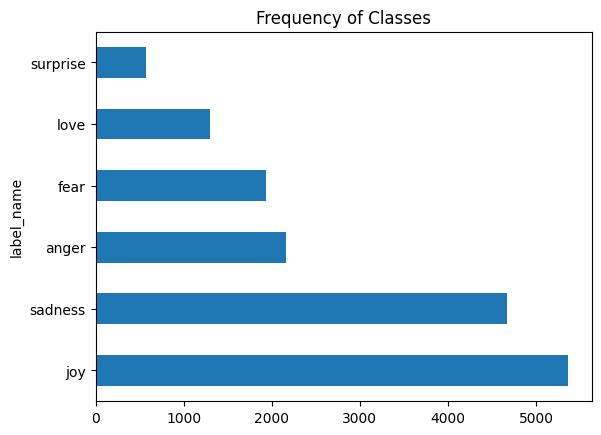

In [22]:


import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=False).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [23]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
encoded_text = tokenizer("I am utkarsh")
print(encoded_text)

{'input_ids': [101, 1045, 2572, 21183, 6673, 4095, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'am', 'ut', '##kar', '##sh', '[SEP]']


In [26]:
# it will pad it to the maximum length in the batch; truncate will truncate the size to model's maximum context size
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [28]:
emotions['train'][:2]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0


In [30]:
emotions.reset_format()
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [31]:
#we can apply it across all the splits in the corpus in a single line of code by using map function;default batch size=entire dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [32]:
emotions_encoded['train'][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [33]:
import torch
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [34]:
torch.cuda.is_available()

True

In [35]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [36]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [24]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [25]:
outputs.last_hidden_state[0][0].shape

torch.Size([768])

In [26]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [37]:
def extract_hidden_states(batch):
# Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
# Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
# Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [38]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [39]:
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])

In [40]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [42]:
!pip install numpy==1.23.4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
albumentations 1.4.0 requires numpy>=1.24.4, but you have numpy 1.23.4 which is incompatible.
apache-beam 2.46.0 requires 

In [43]:
import numpy as np
np.__version__

'1.26.4'

In [44]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [49]:
emotions_hidden['train']['hidden_state'][0]

tensor([-1.1675e-01,  9.8571e-02, -1.2963e-01, -9.5018e-02, -2.8083e-01,
        -1.3222e-01,  2.2748e-01,  2.3100e-01,  1.6752e-01, -2.4663e-01,
         2.1755e-02, -1.0200e-01, -1.8098e-01,  2.2351e-01,  2.0275e-01,
         1.1693e-01, -6.9554e-04,  1.2025e-01, -1.4220e-04, -6.0743e-02,
        -1.4382e-01, -3.1201e-01, -1.0877e-01,  1.1822e-01, -7.3939e-02,
         7.2635e-02,  2.1319e-01, -2.9570e-01,  1.0432e-01, -1.4980e-01,
         1.1913e-01,  1.3559e-01, -2.0512e-01,  7.9983e-02, -1.2340e-01,
         2.4995e-02,  1.1948e-02,  1.0090e-02,  1.3740e-01, -1.3440e-02,
        -1.1266e-01, -7.7647e-02, -1.3007e-01, -7.1688e-02,  8.5297e-02,
        -5.4750e-02, -2.1881e+00, -5.0468e-02, -3.2211e-01, -1.6245e-01,
         3.1700e-01, -1.9575e-01,  1.3216e-01,  3.7076e-01, -5.4104e-02,
         3.5674e-01, -1.9445e-01,  3.1695e-01, -2.2348e-02,  9.1785e-02,
         2.9930e-01,  2.1970e-01, -1.4083e-01, -7.3253e-03, -7.7053e-02,
         2.2294e-01, -8.2599e-02,  3.5193e-01, -1.1

In [50]:
emotions_hidden['train']['hidden_state'].shape

torch.Size([16000, 768])

In [51]:
device

device(type='cuda')

In [52]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [54]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
#model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir='/kaggle/working/Firstcut_emotion_distillbert',
num_train_epochs=2,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
evaluation_strategy="epoch",
disable_tqdm=False,
logging_steps=logging_steps,
log_level="error")

2024-07-06 07:32:33.510972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 07:32:33.511091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 07:32:33.640467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [55]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [56]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_encoded["train"],
eval_dataset=emotions_encoded["validation"],
tokenizer=tokenizer)
trainer.train();

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.834000,0.315038,0.912000,0.912078
2,0.253600,0.218519,0.927000,0.927094


In [57]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [58]:
preds_output.metrics

{'test_loss': 0.21851898729801178,
 'test_accuracy': 0.927,
 'test_f1': 0.9270939339273931,
 'test_runtime': 2.3478,
 'test_samples_per_second': 851.874,
 'test_steps_per_second': 13.63}

In [59]:
preds_output.predictions[0]

array([ 4.438177 , -0.6047667, -1.2208525, -1.1038864, -1.0871526,
       -1.6776767], dtype=float32)

In [60]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [61]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [62]:
y_preds

array([0, 0, 2, ..., 1, 1, 1])

In [63]:
y_valid=emotions_encoded["validation"]['label'].numpy()


In [64]:
labels=emotions_encoded["train"].features['label'].names

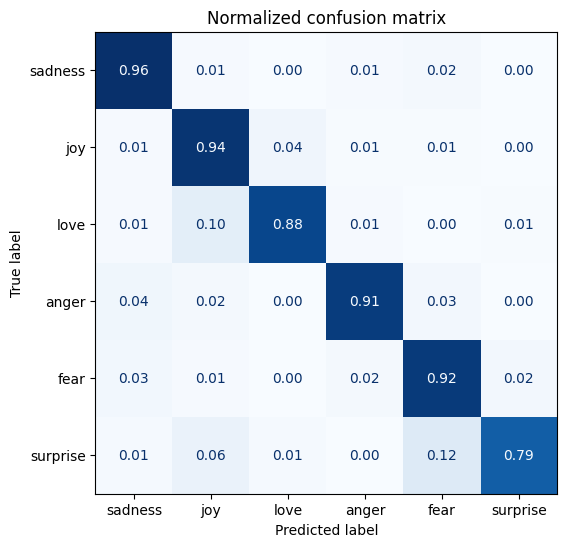

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(y_preds, y_valid, labels)